# [20250323] [Image Segmentation Tutorial](https://www.tensorflow.org/tutorials/images/segmentation#what_is_image_segmentation)

- A brief understanding of how image segmentation works in TensorFlow

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-lp92mmlo
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-lp92mmlo
  Resolved https://github.com/tensorflow/examples.git to commit fed63294c10c71b7da028e0e75de9ff68ac56d17
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1741282361.1454860421494433302046033067432040489300359736599-py3-none-any.whl size=301643 sha256=a27f7fb18968b37c9fd1185ccbe5da67a3e5811b72548dc76f4bcee3dd53d1e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-24b0zty7/wheels/91/9b/e8/6ae2ecc930bd726c578e35b313e987a687bc5ce03c3a42c2d5
Successfully built tensorflow-examples


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.Q6HBD4_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.Q6HBD4_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [4]:
# tf.data.Dataset object contains a dict of tf.Tensors
# dataset['train']'s type: tensorflow.python.data.ops.prefetch_op._PrefetchDataset
# _PrefetchDataset is subclass of tf.data.Dataset!

In [5]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1 # label [1, 2, 3] to [0, 1, 2]
  return input_image, input_mask

In [6]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

## Set Constants

In [7]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

`tf.data.Dataset` methods: [link](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#methods)

In [8]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes!!
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [10]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)

In [11]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

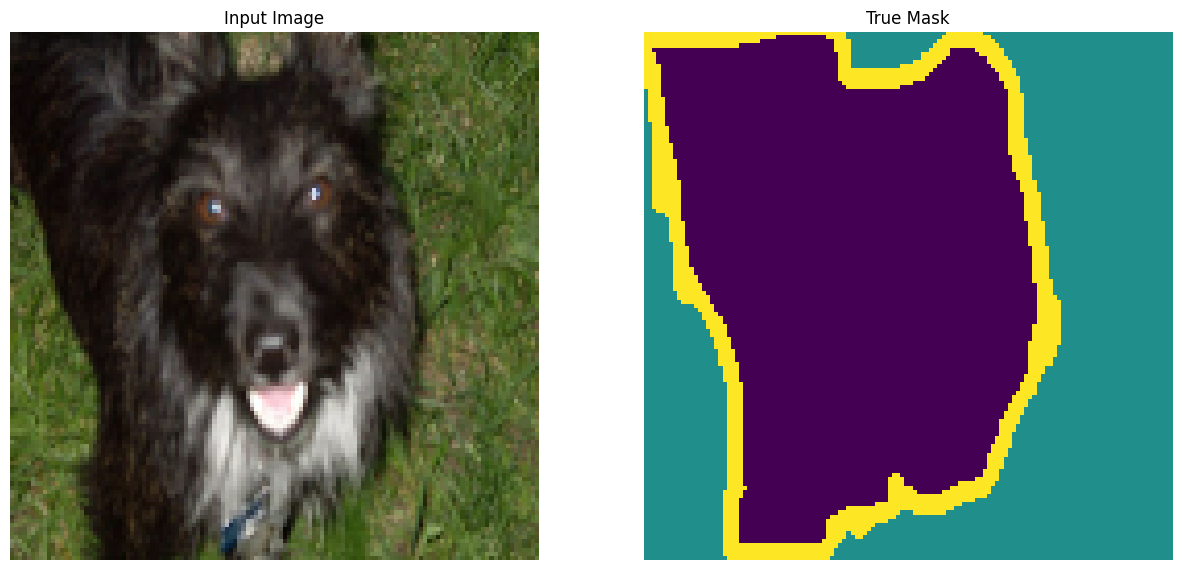

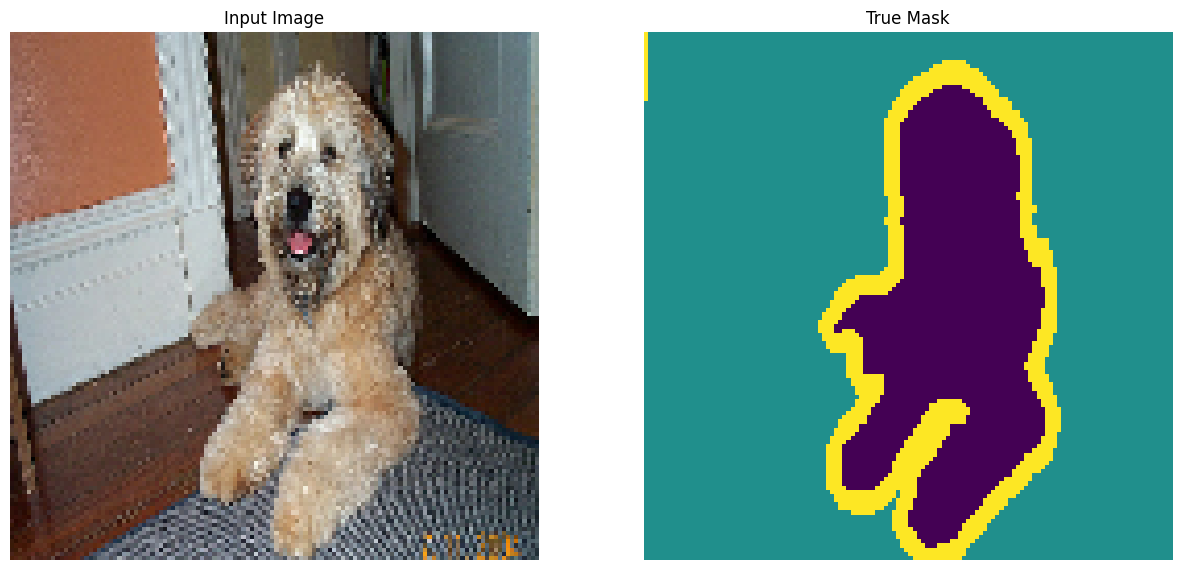

In [12]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [13]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=[128, 128, 3],
    include_top=False # exclude fully-connected layer
)

# there are the Base model's layer names
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

for layer in base_model.layers:
    if layer.name in layer_names:
      print(f'{layer.name}: {layer}')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
block_1_expand_relu: <ReLU name=block_1_expand_relu, built=True>
block_3_expand_relu: <ReLU name=block_3_expand_relu, built=True>
block_6_expand_relu: <ReLU name=block_6_expand_relu, built=True>
block_13_expand_relu: <ReLU name=block_13_expand_relu, built=True>
block_16_project: <Conv2D name=block_16_project, built=True>


In [14]:
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [17]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1) # W x H
  pred_mask = pred_mask[..., tf.newaxis] # W x H x 1
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


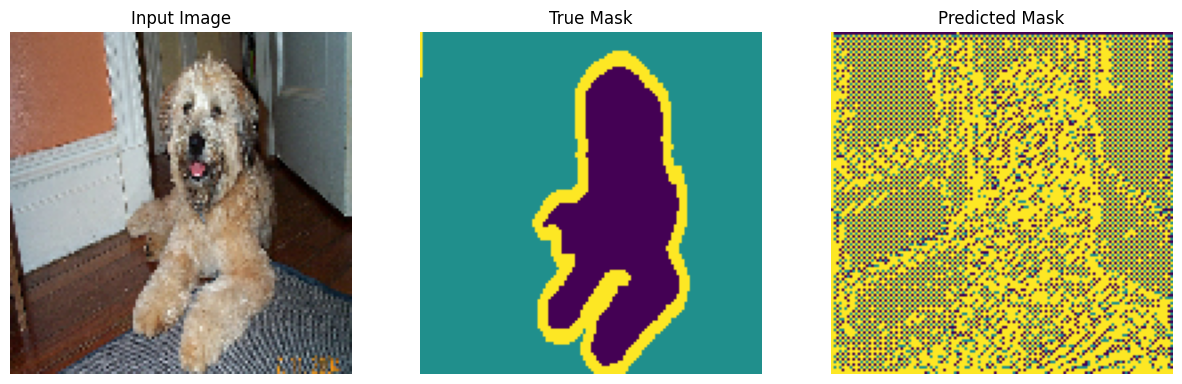

In [19]:
show_predictions()

In [20]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


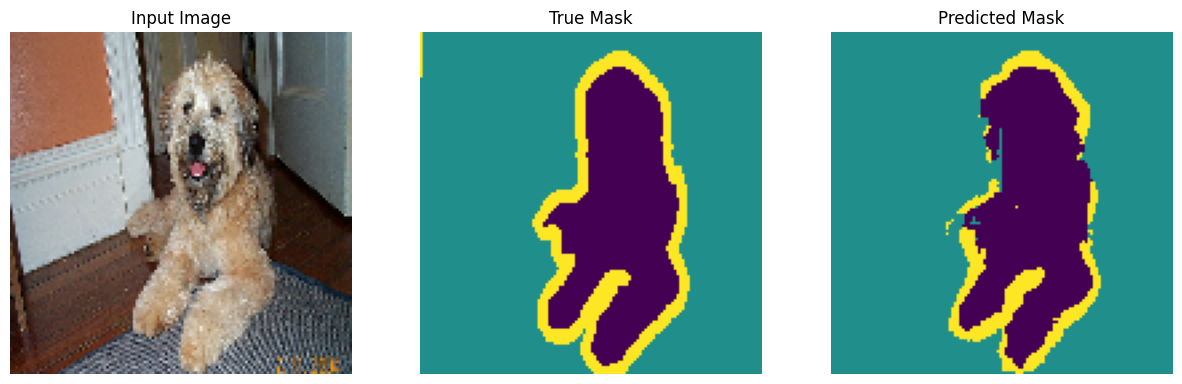


Sample Prediction after epoch 20

57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.9285 - loss: 0.1753 - val_accuracy: 0.9039 - val_loss: 0.2771


In [21]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

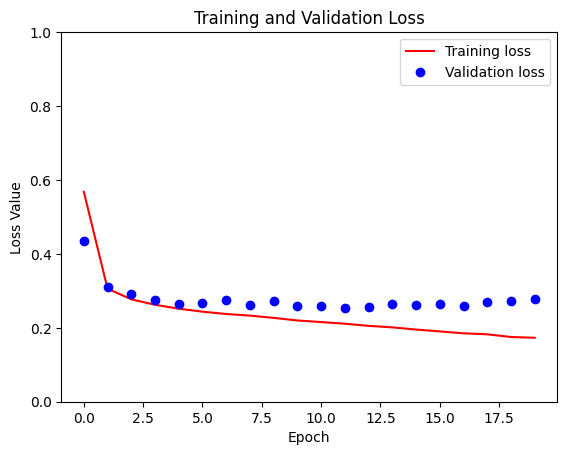

In [22]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step


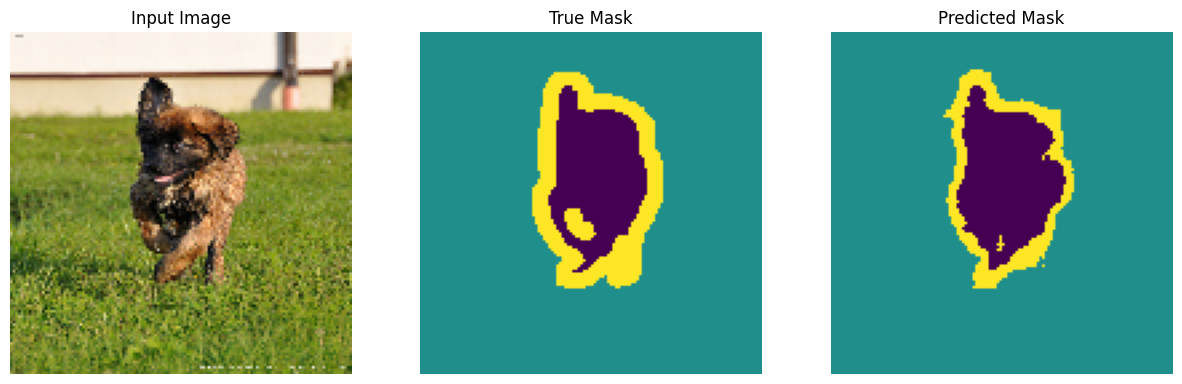

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


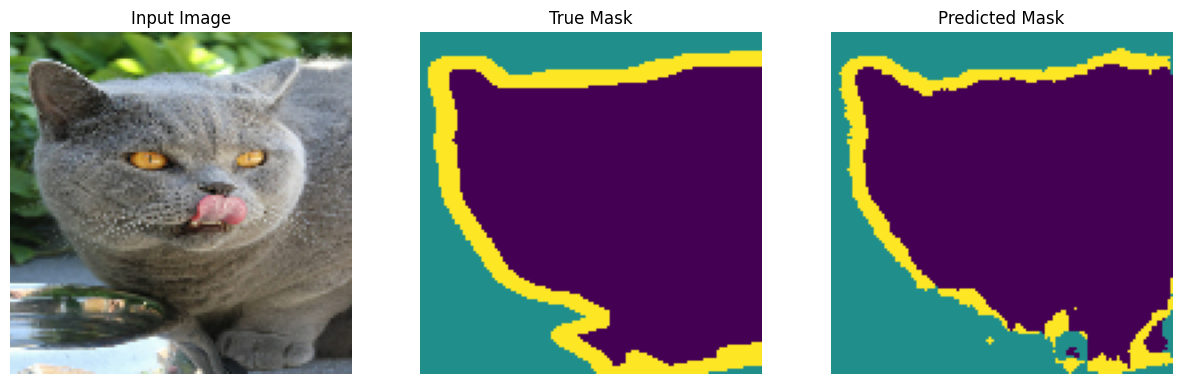

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


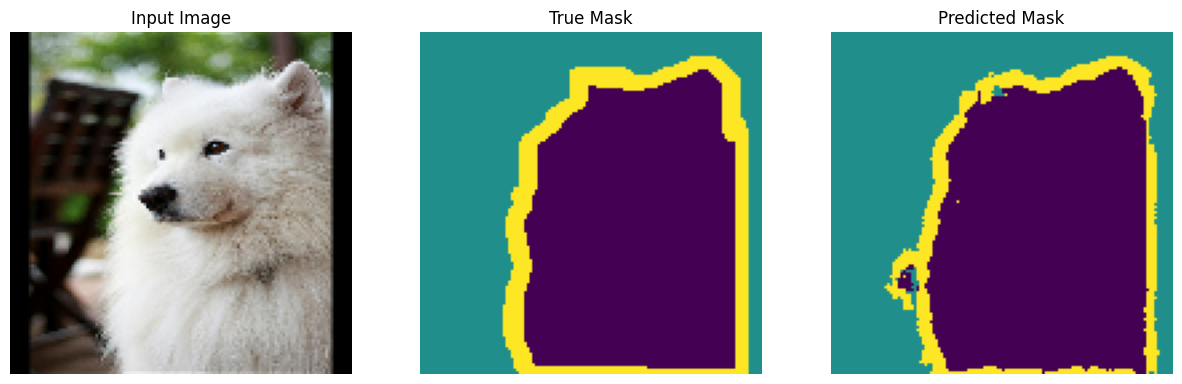

In [23]:
show_predictions(test_batches, 3)